In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import warnings
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, auc, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from matplotlib.colors import ListedColormap

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

# **Load and merge datasets**

The data is split between two datasets one containing rows with overtakes and overtaken scenarios and another larger dataset with non-scenario rows, describing the vehicle driving without encountering any scenario. Both datasets contain identical columns but they are not in the same order to this must be fixed before the datasets can be merged.

In [2]:
# import scenario dataset
df1 = pd.read_csv('output_file-overtakes.csv')
print("shape:", df1.shape)
df1.head()

shape: (505, 1254)


,vehicle_id,ego_veh_overtakes_other,ego_veh_overtaken_by_other,vehicle_type,t1,s1,a1,d1,v1,t2,...,t249,s249,a249,d249,v249,t250,s250,a250,d250,v250
0,30,Y,N,Seat Leon,NaN,NaN,NaN,NaN,NaN,NaN,...,1.687391e+09,L,163.618163,7.944192,-8.369957,1.687391e+09,L,164.704145,8.347662,-8.401554
1,27,Y,N,Volkswagen T2,NaN,NaN,NaN,NaN,NaN,NaN,...,1.687391e+09,R,161.611545,8.528953,-4.206907,1.687391e+09,R,162.413108,8.722921,-4.177211
2,27,N,Y,Volkswagen T2,NaN,NaN,NaN,NaN,NaN,NaN,...,1.687391e+09,R,21.311273,9.286888,2.630563,1.687391e+09,R,20.161771,9.784289,2.617315
3,27,Y,N,Volkswagen T2,NaN,NaN,NaN,NaN,NaN,NaN,...,1.687391e+09,R,153.736123,10.309084,-4.720090,1.687391e+09,R,153.520792,11.149581,-4.539961
4,26,Y,N,Diamondback Century,NaN,NaN,NaN,NaN,NaN,NaN,...,1.687391e+09,R,163.206761,8.610647,-5.929351,1.687391e+09,R,164.210856,9.176173,-5.894443


In [3]:
# import no-scenario dataset
df2 = pd.read_csv('output_file-no_scenarios.csv')
print("shape:", df2.shape)
df2.head()

shape: (16497, 1254)


,vehicle_id,ego_veh_overtakes_other,ego_veh_overtaken_by_other,vehicle_type,t250,s250,a250,d250,v250,t249,...,t2,s2,a2,d2,v2,t1,s1,a1,d1,v1
0,29,N,N,Lincoln Mkz 2017,1.688947e+09,L,0.329167,15.778938,-0.702104,1.688947e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29,N,N,Lincoln Mkz 2017,1.688947e+09,L,0.329167,15.778938,-0.702104,1.688947e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29,N,N,Lincoln Mkz 2017,1.688947e+09,L,0.375836,15.739118,-0.851417,1.688947e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29,N,N,Lincoln Mkz 2017,1.688947e+09,L,0.375836,15.739118,-0.851417,1.688947e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29,N,N,Lincoln Mkz 2017,1.688947e+09,L,0.420837,15.696234,-0.851373,1.688947e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def reorder_cols(dataframe):
    col_indicators = ['t', 's', 'a', 'd', 'v']
    new_col_headers = dataframe.columns.values.tolist()[0:4]

    for ind in col_indicators:
        for i in range(1, 250+1):
            new_col_headers.append(ind + str(i))

    return dataframe[new_col_headers]

In [5]:
# reorder the columns of both dataframes so they are consistent

df1 = reorder_cols(df1)
df2 = reorder_cols(df2)

In [6]:
# join both dataframes into a single dataframe, shuffle the rows 
# and save the resultant dataframe as a csv file.

df = [df1, df2]
df = pd.concat(df)

df = df.sample(frac=1).reset_index(drop=True)
df.to_csv("output_file.csv", encoding='utf-8', index=False)

In [7]:
# load joined dataframe from file

df = pd.read_csv('output_file.csv')
print("shape:", df.shape)

shape: (17002, 1254)


# **Data Investigation**

column names:<br>
>vehicle_id = identifier assigned to vehicle by carla (int)<br>
overtakes = ego vehicle overtakes other vehicle (Y/N)<br>
overtaken = ego vehicle is overtaken by other vehicle (Y/N)<br>
vehicle_type = name of vehicle (string)<br>
t1-250 = timestamp (float: epoch)<br>
s1-250 = side of ego vehicle (char : L/R)<br>
a1-250 = angle from center front of ego vehicle (float : -180 to 180)<br>
d1-250 = distance in meters from ego vehicle (float)<br>
v1-250 = velocity delta between the two vehicles (float)

# **Data cleaning**

#### **Drop unnecessary columns**
unnecessary columns: ['vehicle_id', 'vehicle_type', 't1' ... 't250', 's1' ... 's250']
The vehicle_id and the vehicle_type do not contain any information that would help the prediction of the target value and should therefor be removed. The 's' columns indicating the side that the vehicle is on relative to the ego vehicle is unnecessary because this information is captured in the 'a' column (angle from center front of ego vehicle), the angle being positive or negative will indicate side. The 't' columns are unnecessary as the data is passed to the model in a ordered format. 

In [8]:
def drop_columns(dataframe, singular_columns=None, 
                 timeseries_columns=None, number_to_drop=250):
    cols_to_delete = []

    if singular_columns:
        cols_to_delete = singular_columns
    
    if timeseries_columns:        
        for ind in timeseries_columns:
            for i in range(1, number_to_drop+1):
                cols_to_delete.append(ind + str(i))

    return dataframe.drop(cols_to_delete, axis=1)

In [9]:
regular_columns_to_drop = ["vehicle_id", "vehicle_type"]
timeseries_columns_to_drop = ['t', 's']

print("Number of columns in dataframe before columns dropped:", df.shape[1])
df = drop_columns(df, regular_columns_to_drop, timeseries_columns_to_drop)
print("Number of columns in dataframe after columns dropped:", df.shape[1])

Number of columns in dataframe before columns dropped: 1254
Number of columns in dataframe after columns dropped: 752


Rename target columns

In [10]:
df = df.rename(columns={'ego_veh_overtakes_other': "overtakes", 
                        'ego_veh_overtaken_by_other': "overtaken"})

### **Change datatypes**
Change the 'overtakes' and 'overtaken' to boolean values

In [11]:
df['overtakes_bool'] = 0
df['overtaken_bool'] = 0

df.loc[df.overtakes == "Y", "overtakes_bool"] = 1
df.loc[df.overtaken == "Y", "overtaken_bool"] = 1

df = df.drop(["overtakes", "overtaken"], axis=1)
df = df.rename(columns={"overtakes_bool": "overtakes", 
                        "overtaken_bool": "overtaken"})

In [12]:
print("overtakes sum:", df['overtakes'].sum())
print("overtaken sum:", df['overtaken'].sum())

overtakes sum: 299
overtaken sum: 206


# Data Visulization

In [13]:
def NormalizeData(data, limit):
    start = 0
    end = limit
    width = end - start
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * width + start

def get_cols_as_lists(sample_row):
    a = []
    v = []
    d = []

    for i in range(1, int((sample_row.shape[1] -2) /3) +1):
        if not math.isnan(sample_row.at[0, "a" + str(i)]):
            a.append(sample_row.at[0, "a" + str(i)])
            v.append(sample_row.at[0, "v" + str(i)])
            d.append(sample_row.at[0, "d" + str(i)])
    
    return a, v, NormalizeData(d, 50)

def graph_6_example_rows(dataframe):

    cols = 3
    rows = 2

    fig, axs = plt.subplots(rows, cols, figsize=(12, 10))

    for r in range(rows):
        for c in range(cols):
            if c == 0:      
                sample = dataframe[(dataframe['overtakes'] > 0)].sample(n=1)
                title = 'ego vehicle overtakes other\nrow: ' + str(sample.iloc[0].name) if r == 0 else 'row: ' + str(sample.iloc[0].name)
            if c == 1:
                sample = dataframe[(dataframe['overtaken'] > 0)].sample(n=1)
                title = 'ego vehicle is overtaken by other\nrow: ' + str(sample.iloc[0].name) if r == 0 else 'row: ' + str(sample.iloc[0].name)
            if c == 2:
                sample = dataframe[(dataframe['overtakes'] < 1) & (dataframe['overtaken'] < 1)].sample(n=1)
                title = 'No scenario\nrow: ' + str(sample.iloc[0].name) if r == 0 else 'row: ' + str(sample.iloc[0].name)

            axs[r, c].set_title(title)    
            sample_idx = sample.iloc[0].name
            sample.reset_index(drop=True, inplace=True)        
            a, v, d = get_cols_as_lists(sample)
        
            if c == 0:
                for idx in range(len(a) -1, -1, -1):
                    if (a[idx] < 75) and (d[idx] > (0.2 * a[idx]) + 5):
                        axs[r, c].axvspan(idx, 0, alpha=0.1, color='tan', label="ego behind")
                        break
                for idx in range(len(a)):
                    if (a[idx] > 105) and (d[idx] > (-0.2 * a[idx]) + 41):
                        axs[r, c].axvspan(idx, len(a), alpha=0.1, color='limegreen', label="ego ahead")
                        break

            if c == 1:
                for idx in range(len(a)):
                    if (a[idx] < 75) and (d[idx] > (0.2 * a[idx]) + 5):
                        axs[r, c].axvspan(idx, len(a), alpha=0.1, color='tan', label="ego behind")
                        break  
                for idx in range(len(a) -1, -1, -1):
                    if (a[idx] > 105) and (d[idx] > (-0.2 * a[idx]) + 41):
                        axs[r, c].axvspan(idx, 0, alpha=0.1, color='limegreen', label="ego ahead")
                        break
        
            axs[r, c].plot(a, label="angle")
            axs[r, c].plot(v, label="speed delta")
            axs[r, c].plot(d, label="distance")
            axs[r, c].set_ylim([-20, 180])

            if r == 0 and c == 0:
                axs[r, c].legend()

    for ax in axs.flat:
        ax.set(xlabel='time', ylabel='y-label')

    for ax in axs.flat:
        ax.label_outer()

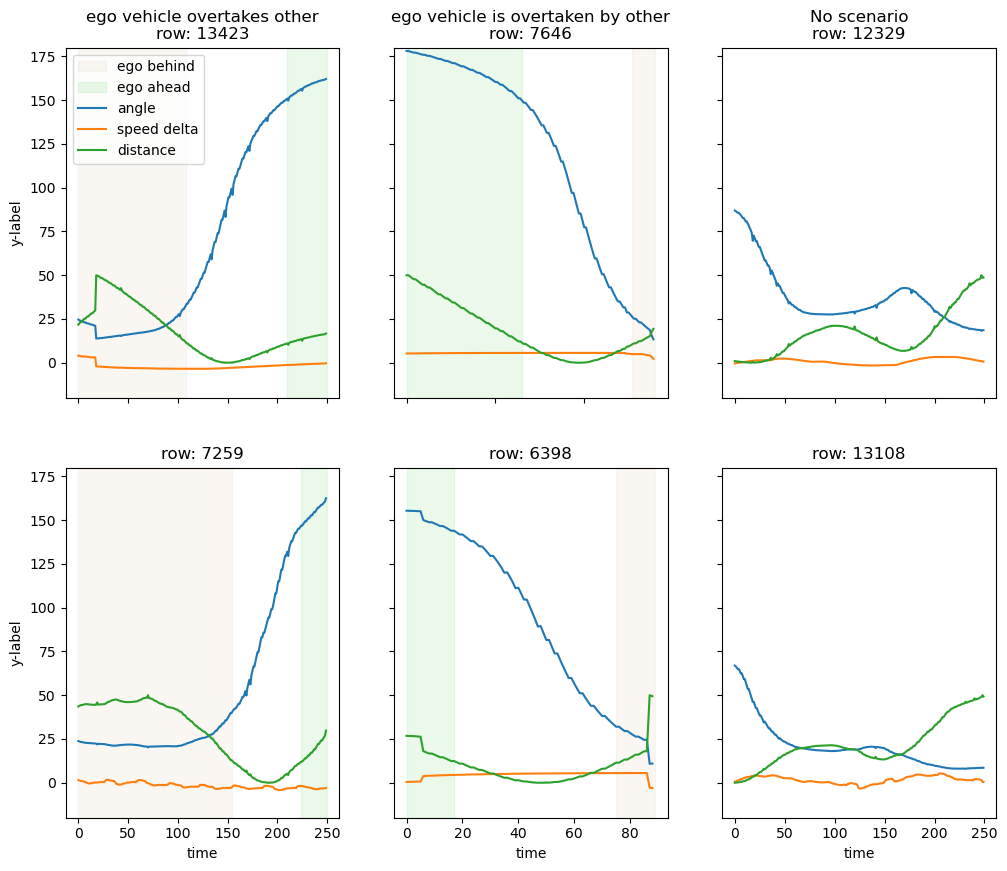

In [14]:
graph_6_example_rows(df)

### **Dealing with null values**

Visualize the distribution of nan values in the dataset

(17002, 752)


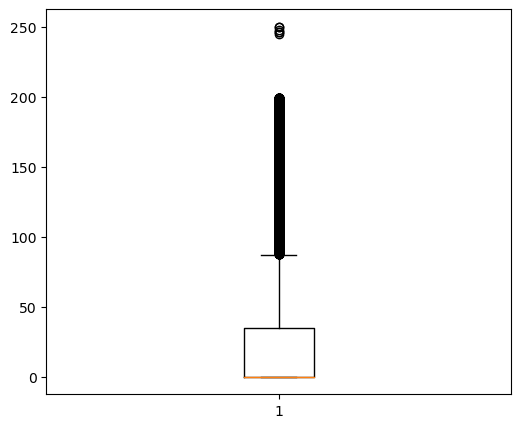

In [15]:
print(df.shape)

figure = plt.figure(figsize =(6, 5))  
plt.boxplot([x//3 for x in df.isnull().sum(axis=1)])
plt.show()

First we drop any column that has more than 200 nan values per timeseries column type, as a minimum of 50 timesteps for angle, distance, and velocity_delta are required. 

In [16]:
nans = [x//3 for x in df.isnull().sum(axis=1)]
max_no_nans_allowed = 200

count = len([i for i in nans if i > max_no_nans_allowed])
print("The number of rows with more than " + str(max_no_nans_allowed) + " nans: " + str(count))

The number of rows with more than 200 nans: 6


In [17]:
nans_sorted_indexes = sorted(range(len(nans)), key=lambda k: nans[k])

delete_index_list = []

for i in range(-1, -len(nans_sorted_indexes), -1):
    index = nans_sorted_indexes[i]
    if df.iloc[[index]].isna().sum().sum() /3 > max_no_nans_allowed:
        delete_index_list.append(index)
    else:
        break
            
print(delete_index_list)

[3020, 1086, 8784, 9238, 2306, 10343]


In [18]:
df = df.drop(index=delete_index_list)
df.reset_index(drop=True, inplace=True)

nans = [x//3 for x in df.isnull().sum(axis=1)]
count = len([i for i in nans if i > max_no_nans_allowed])
print("The number of rows with more than " + str(max_no_nans_allowed) + " nans: " + str(count))

The number of rows with more than 200 nans: 0


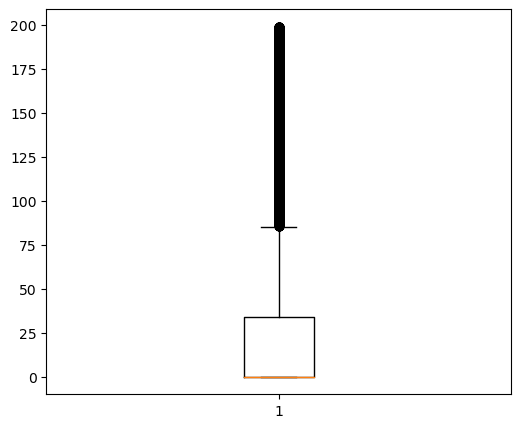

In [19]:
figure = plt.figure(figsize =(6, 5))  
plt.boxplot([x//3 for x in df.isnull().sum(axis=1)])
plt.show()

# Make number of timesteps consistent

Regarding the timeseries features (angle from center, velocity delta, distance), many of these have an inconsistent number of timesteps across the rows in the dataset, as can seen by the number of nan values they contain. In order to make this consistant for each row we will draw a line intercepting each point (as in a line graph) then divide the x asis into a consistent number and determine a new y values based on the intercept with the line. We thereby generate a consistent number of points representing each overtake scenario which can be passed to the model. Something to note, although the number of timesteps is now consistent between rows the timestep duration is not.

In [20]:
def delete_last_n_timesteps(dataframe, feature_indicators, number_of_steps_to_delete):
    cols_to_delete = []
    
    for indicator in feature_indicators:
        for i in range(int((dataframe.shape[1] -2) /3), int((dataframe.shape[1] -2) /3) -number_of_steps_to_delete, -1):
            cols_to_delete.append(indicator + str(i))
    
    dataframe = dataframe.drop(cols_to_delete, axis=1)
        
    return dataframe

In [21]:
def regularize_feature_timesteps(dataframe, no_of_timesteps, feature_indicators):
    timeseries_features = [[],[],[]]

    for idx, indicator in enumerate(feature_indicators):
        for i in range(1, int((dataframe.shape[1] -2) /3) +1):
            timeseries_features[idx].append(indicator + str(i))
        
    for row_idx in range(dataframe.shape[0]):
        print(str(row_idx) + "/" + str(dataframe.shape[0]), end = "\r")
    
        for feat_idx, timeseries_feature in enumerate(timeseries_features):        
            y = dataframe.loc[row_idx, timeseries_feature].to_numpy()
            y = y[np.logical_not(np.isnan(y))]
            x = [*range(1, len(y) +1)]
            intercept_increment = len(y) / (no_of_timesteps -1)

            for i in range(no_of_timesteps):
                dataframe.at[row_idx, feature_indicators[feat_idx] + str(i + 1)] = np.interp(intercept_increment * i, x, y)
            
    dataframe = delete_last_n_timesteps(dataframe, feature_indicators, 250 - no_of_timesteps)
        
    return dataframe

In [22]:
reduce_to_n_timesteps = 100

df = regularize_feature_timesteps(df, reduce_to_n_timesteps, ["a", "d", "v"])

In [23]:
df.to_csv("output_file_consistent.csv", encoding='utf-8', index=False)

In [24]:
df = pd.read_csv('output_file_consistent.csv')
print("shape:", df.shape)

shape: (16996, 302)


# Data transformation
Synthetic Minority oversampling technique (SMOTE) which attempts to balance the data set by creating synthetic instances. And train the balanced data set using any of the classification algorithm.
In this step we identifiy the rows where an 'overtaken' scenario (ego vehicle is overtaken by another vehicle) is observed. We reverse the 'angle from center' data, flip the sign on the 'velocity delta' data, change the 'overtakes' column to '1' and the 'overtaken' column to '0', thereby creating a new row where the ego vehicle was detected overtaking another vehicle. We also perform the opposite operation on all columns where an 'overtakes' scenario was detected.

In [25]:
print("overtakes sum:", df['overtakes'].sum())
print("overtaken sum:", df['overtaken'].sum())
print("Ratio of overtakes to non-overtake rows " + str(df['overtakes'].sum()) + ":" + str(df.shape[0] - df['overtakes'].sum()))
print("Overtakes as percent of total:" + str(round(df['overtakes'].sum() / df.shape[0] * 100, 2)) + "%")

overtakes sum: 295
overtaken sum: 204
Ratio of overtakes to non-overtake rows 295:16701
Overtakes as percent of total:1.74%


In [26]:
def transform_rows(dataframe, rows_to_transform):
    timeseries_columns = ['a', 'v']
    
    for index , row in rows_to_transform.iterrows():
        for i in range(1, 100 +1): 
            if not math.isnan(rows_to_transform.at[index, "a" + str(i)]):
                rows_to_transform.at[index, "a" + str(i)] = 180 - rows_to_transform.at[index, "a" + str(i)]
                rows_to_transform.at[index, "v" + str(i)] = -rows_to_transform.at[index, "v" + str(i)]
        rows_to_transform.at[index, "overtakes"] = 1 - rows_to_transform.at[index, "overtakes"]
        rows_to_transform.at[index, "overtaken"] = 1 - rows_to_transform.at[index, "overtaken"]

    dataframe = pd.concat([dataframe, rows_to_transform])
    dataframe = dataframe.sample(frac = 1)
    dataframe.reset_index(drop=True, inplace=True)

    return dataframe

In [27]:
df = transform_rows(df, df[df.overtaken > 0])
df = transform_rows(df, df[df.overtakes > 0])

print("overtakes sum:", df['overtakes'].sum())
print("overtaken sum:", df['overtaken'].sum())
print("Overtakes as percent of total:" + str(round(df['overtakes'].sum() / df.shape[0] * 100, 2)) + "%")

overtakes sum: 499
overtaken sum: 703
Overtakes as percent of total:2.82%


# Dealing with an imbalanced dataset

As we can see currently the dataset is highly imbalanced, even after generating additional overtake rows (the prediction target) they still make up less than 3 percent of the overall dataset. This will encourage the model to be conservative and predict against the overtakes class as doing so will achieve a higher accuracy. With the dataset in its current composition if the model predicts 100 percent non-overtakes then it will achieve a 97 percent accuracy, this is clearly a problem that must be addressed. There are a few solutions to deal with this problem which we will now discuss. 

the ratio should be representitive

**Under sampling:** Reduce the number of non-overtake rows until the dataset is balanced. If we under-sample before train-test split we will lose a significant proportion of the data, but more importantly, If the model is trained on a balanced dataset, we lose any information regarding the frequency of one class over another, and because the model is trained and evaluated on the same dataset it will probably achieve a high degree of accracy but fail to reproduce this performance on unseen data. If we undersample the data after the train-test split, the model will underfit the data because it will be trained on balanced data but validated/tested on imbalanced data.

**Cross validation** Another option to address an imbalanced dataset is by means of cross validation. We should generate a number of balanced folds with an even disstribution of classes. Each fold should ensure a random selection from across the dataset. Each fold will have a similar selection from the under-represented class because there are not many examples to select from and a substantially different selection of the over-represented class.

**Penelised Model** This is not a pre-processing step, this method is part of configuration of the model.

Of these methods Undersampling produced the best results but as expected the accuracy reported on the test data did not translate to unseen data. The Penelised model method did show some improvement over vanilla logistic regression but the improvement was modest.
After testing each of these methods using a logistic regression classifier I found the accuracy results were still poor. 

In [28]:
# reduction_percent = 1 - (df['overtakes'].sum() / df.shape[0])

# # df = df.drop(df[(df['overtakes'] < 1) & (df['overtaken'] < 1)].sample(frac=reduction_percent).index)
# df = df.drop(df[(df['overtakes'] < 1)].sample(frac=reduction_percent).index)
# df.reset_index(drop=True, inplace=True)

# print("Ratio of overtakes to non-overtake rows " + str(df['overtakes'].sum()) + ":" + str(df.shape[0] - df['overtakes'].sum()))
# print("Overtakes as percent of total:" + str(round(df['overtakes'].sum() / df.shape[0] * 100, 2)) + "%")

# Normalize data
Because we are working with timeseries data we are normalizing across 2 dimensions, this means that the max and min values may not exist in the current row. Instead of iterating over the whole dataset a second time we obtained these values when we were making the number of timesteps consistent.

In [29]:
def find_minmax_timeseries_features(dataframe, feature_indicators):
    timeseries_features = [[],[],[]]
    min_max_vals = [[float('inf'), -float('inf')],
                        [float('inf'), -float('inf')],
                        [float('inf'), -float('inf')]]

    for idx, indicator in enumerate(feature_indicators):
        for i in range(1, int((dataframe.shape[1] -2) /3) +1):
            timeseries_features[idx].append(indicator + str(i))
        
    for row_idx in range(dataframe.shape[0]):
        print("Finding minimum and maxiumum values: " + str(row_idx) + "/" + str(dataframe.shape[0]), end = "\r")
    
        for feat_idx, timeseries_feature in enumerate(timeseries_features):        
            y = dataframe.loc[row_idx, timeseries_feature].to_numpy()

            if np.min(y) < min_max_vals[feat_idx][0]: min_max_vals[feat_idx][0] = np.min(y)
            if np.max(y) > min_max_vals[feat_idx][1]: min_max_vals[feat_idx][1] = np.max(y)
    
    return min_max_vals

In [30]:
def normalize_row(arr, target_minmax, feature_minmax):
    norm_arr = []
    diff = target_minmax[1] - target_minmax[0]
    diff_arr = feature_minmax[1] - feature_minmax[0]
    
    for i in arr:
        temp = (((i - feature_minmax[0]) *diff) /diff_arr) + target_minmax[0]
        norm_arr.append(temp)
        
    return norm_arr

In [31]:
def normalize_timeseries_columns(dataframe, timeseries_column_indicators, min_max_vals):
    timeseries_column_names = [[],[],[]]
    
    for idx, column_indicator in enumerate(timeseries_column_indicators):
        for i in range(1, int((dataframe.shape[1]-2) /3) +1):
            timeseries_column_names[idx].append(column_indicator + str(i))

    for row_idx in range(df.shape[0]):  
        print("Normalizing timeseries features: " + str(row_idx) + "/" + str(df.shape[0]), end = "\r")

        for feat_idx, timeseries_feature in enumerate(timeseries_column_names):
            norm = normalize_row(dataframe.loc[row_idx, timeseries_feature].to_numpy(), 
                             (0, 1), 
                             (min_max_vals[feat_idx][0], min_max_vals[feat_idx][1])) 

            for i in range(100):
                dataframe.at[row_idx, timeseries_column_indicators[feat_idx] + str(i +1)] = norm[i]
                
    return dataframe

In [32]:
min_max = find_minmax_timeseries_features(df, ["a", "d", "v"])
df = normalize_timeseries_columns(df, ["a", "d", "v"], min_max)

In [33]:
df.to_csv("output_file_consistent_norm.csv", encoding='utf-8', index=False)

In [34]:
df = pd.read_csv('output_file_consistent_norm.csv')
print("shape:", df.shape)

shape: (17699, 302)


## Principle Component Analysis

justification for choosing PCA

In [35]:
# y = df[['overtaken']].copy()
y = df[['overtakes']].copy()
X = df.drop(["overtakes", "overtaken"], axis=1)

In [36]:
# Splitting the X and Y into the
# Training set and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [37]:
# Applying PCA function on training
# and testing set of X component

# pca = PCA(n_components = 2)

# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# explained_variance = pca.explained_variance_ratio_
# print("explained_variance:", explained_variance)

In [38]:
# Fitting Logistic Regression To the training set

# overtakes_ratio = df['overtakes'].sum() / df.shape[0]

# # classifier = LogisticRegression(random_state = 0, class_weight={0:overtakes_ratio, 1:1-overtakes_ratio}, max_iter = 1000)
# classifier = LogisticRegression(random_state = 0, class_weight={0:0.03, 1:0.97}, max_iter = 1000)
# # classifier = LogisticRegression(random_state = 0)

# classifier.fit(X_train, y_train.values.ravel())

In [39]:
classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[3435    0]
 [   8   97]]


In [40]:
# Predicting the test set result using
# predict function under LogisticRegression
y_pred = classifier.predict(X_test)

print(y_test['overtakes'].sum())

print(accuracy_score(y_test, y_pred))
print('Accuracy of the XGBoost classifier on train set: {:.2f}'.format(classifier.score(X_train, y_train))) 
print('Accuracy of the XGBoost classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test))) 
print('Recall of the XGBoost classifier on test set: {:.2f}'.format(recall_score(y_test, y_pred))) 
print('Precision of the XGBoost classifier on test set: {:.2f}'.format(precision_score(y_test, y_pred))) 
print('ROC/AUC of the XGBoost classifier on test set: {:.2f}'.format(roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1])))

105
0.9977401129943503
Accuracy of the XGBoost classifier on train set: 1.00
Accuracy of the XGBoost classifier on test set: 1.00
Recall of the XGBoost classifier on test set: 0.92
Precision of the XGBoost classifier on test set: 1.00
ROC/AUC of the XGBoost classifier on test set: 1.00


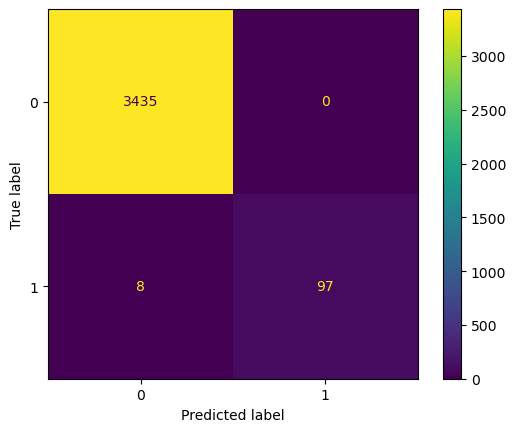

In [41]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [42]:
# pickle.dump(classifier, open("overtakes_xgb_acc99915.pickle", "wb"))

# loaded_model = pickle.load(open("overtakes_model_acc98.pickle", "rb"))
# print(loaded_model.score(X_test, y_test))

# y_pred = loaded_model.predict(X_test)

# print("number of overtakes predicted:", np.sum(y_pred), "of", y_test['overtakes'].sum())
# print(accuracy_score(y_test, y_pred))